In [1]:

import numpy as np
import cv2
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt


In [2]:
def order_points(pts):
    
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [3]:
def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped


In [4]:
def find_puzzle(image,debug=False):
    
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blurred=cv2.GaussianBlur(gray,(7,7),3)
    
    thresh=cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    
    thresh=cv2.bitwise_not(thresh)
    
    if debug:
        plt.figure(figsize=(18,18))
        plt.subplot(221)
        plt.axis('off')
        plt.title("Thresholded image")
        plt.imshow(thresh,cmap='gray')
    
    cnts,_=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts=sorted(cnts,key=cv2.contourArea,reverse=True)
    
    puzzleCnt=None
    
    for c in cnts:
        peri=cv2.arcLength(c,True)
        approx=cv2.approxPolyDP(c,0.02*peri,True)
        
        if len(approx)==4:
            puzzleCnt=approx
            break
    if puzzleCnt is None:
        raise Exception("Could not find the puzzle outline. Try debugging the threshold and contour steps")
        
    if debug:
        output=image.copy()
        cv2.drawContours(output,[puzzleCnt],-1,(0,255,0),2)
        plt.subplot(222)
        plt.axis('off')
        plt.title("Puzzle Outline")
        plt.imshow(output,cmap='gray')
        
    
    puzzle = four_point_transform(image, puzzleCnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))


    if debug:
    # show the output warped image (again, for debugging purposes)
        plt.subplot(223)
        plt.axis('off')
        plt.title("orignal warped")
        plt.imshow(puzzle,cmap='gray')
        
        plt.subplot(224)
        plt.axis('off')
        plt.title("gray warped")
        plt.imshow(warped,cmap='gray')


    return (puzzle, warped)
    

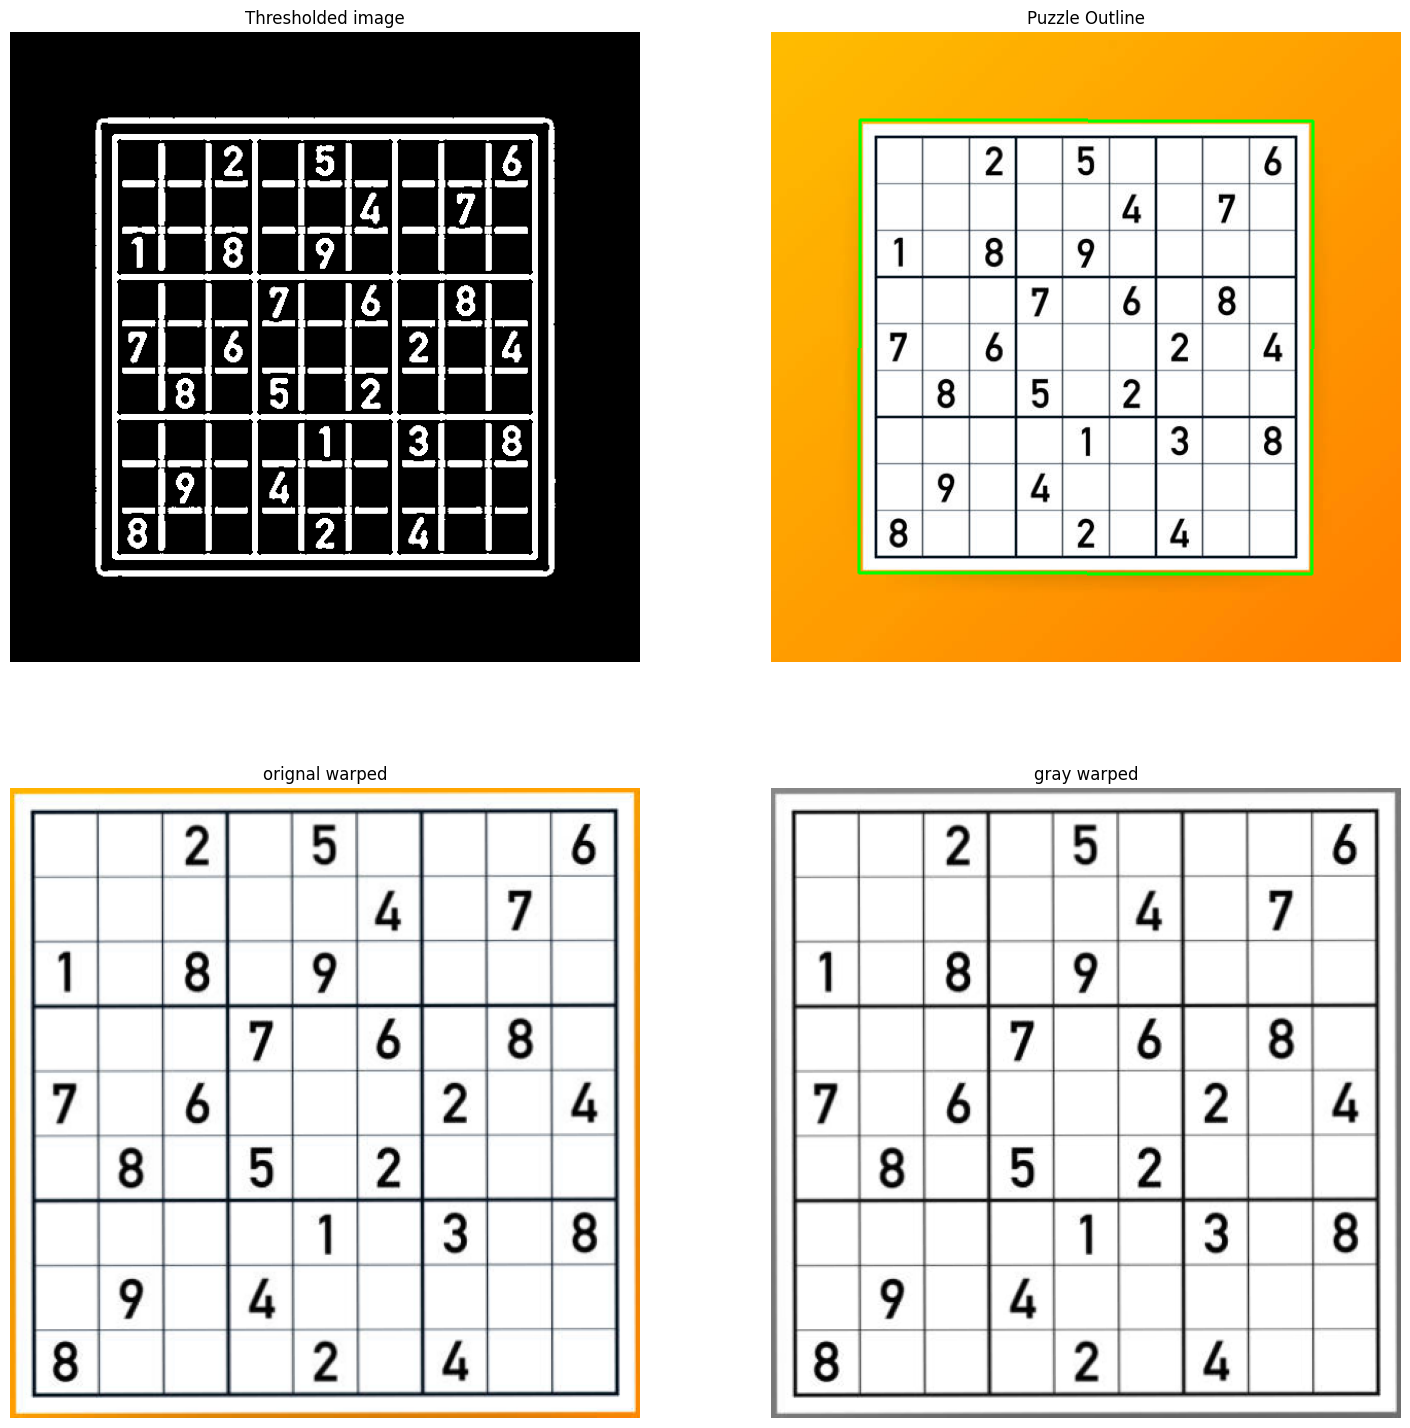

In [5]:
image=cv2.imread('istockphoto-1132323609-612x612.jpg')
a=find_puzzle(image,True)



In [6]:
def extract_digit(cell,debug=False):
    thresh=cv2.threshold(cell,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh=clear_border(thresh)
    
    if debug:
        plt.figure(figsize=(12,12))
        plt.subplot(121)
        plt.title("Thresholded Image")
        plt.axis('off')
        plt.imshow(thresh,cmap='gray')
        
    cnts,_ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    if len(cnts)==0:
        return None
    
    c=max(cnts,key=cv2.contourArea)
    
    mask=np.zeros(thresh.shape,dtype='uint8')
    cv2.drawContours(mask,[c],-1,255,-1)
    
    (h,w)=thresh.shape
    percent_filled=cv2.countNonZero(mask)/float(w*h)
    
    if percent_filled<0.03:
        return None
    
    digit=cv2.bitwise_and(thresh,thresh,mask=mask)
    
    if debug:
        plt.subplot(122)
        plt.title("Digit")
        plt.axis('off')
        plt.imshow(digit,cmap='gray')
        
    return digit

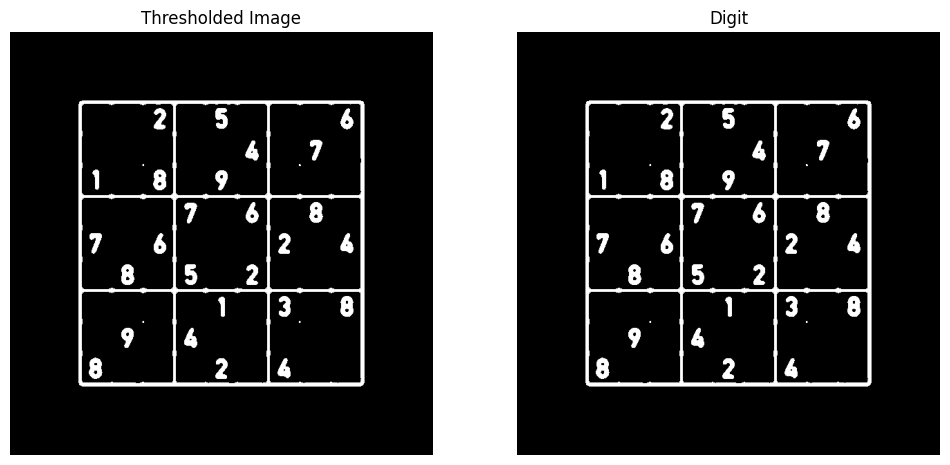

In [7]:
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
blurred=cv2.GaussianBlur(gray,(7,7),3)
b=extract_digit(blurred,True)